# Unlearning by Selective Impair and Repair (UNSIR)

https://arxiv.org/abs/2111.08947

### Zero-glance unlearning
Note that access to the forget data is not required in this post-hoc unlearning technique.

In [1]:
import copy
import gc
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchinfo import summary
from torchvision import transforms
from tqdm import tqdm

In [2]:
drive = None
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
path = "./"
sys.path.append(path)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path = path if drive is None else "/content/drive/MyDrive/self-learn/unlearning"

In [5]:
from constants import *
from utils import (
    set_seed,
    train_data,
    val_data,
    train_loader,
    val_loader,
    fine_labels,
    invTrans,
)
from models import get_model_and_optimizer

set_seed()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
MODEL_NAME = f"CNN_CIFAR_100_ORIGINAL"
print("Model Name:", MODEL_NAME)

Model Name: CNN_CIFAR_100_ORIGINAL


# Setup

In [7]:
target_class = 23
fine_labels[target_class]

'cloud'

In [8]:
def eval(model, val_loader, criterion, device):
    val_losses = []
    correct = 0
    model.eval()

    with torch.no_grad():
        for i, (img, label) in enumerate(val_loader):

            img, label = img.to(device), label.to(device)
            out = model(img)

            loss_eval = criterion(out, label)
            val_losses.append(loss_eval.item())

            pred = out.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    val_loss = np.mean(val_losses)
    val_acc = correct / ((len(val_loader) - 1) * BATCH_SIZE + label.size(0))

    return val_loss, val_acc

In [9]:
forget_idx = np.where(np.array(train_data.targets) == target_class)[0]
forget_mask = np.zeros(len(train_data.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

forget_data = torch.utils.data.Subset(train_data, forget_idx)
retain_data = torch.utils.data.Subset(train_data, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_data, batch_size=BATCH_SIZE, shuffle=False
)
retain_loader = torch.utils.data.DataLoader(
    retain_data, batch_size=BATCH_SIZE, shuffle=False
)

In [10]:
LOAD_EPOCH = 100

model, optimizer = get_model_and_optimizer()
model.load_state_dict(
    torch.load(
        f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{LOAD_EPOCH}_SEED_{SEED}.pt",
        map_location=device,
    )["model_state_dict"]
)
optimizer.load_state_dict(
    torch.load(
        f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{LOAD_EPOCH}_SEED_{SEED}.pt",
        map_location=device,
    )["optimizer_state_dict"]
)
model.to(device)
print("Model and optimizer loaded")

Model and optimizer loaded


In [11]:
t_model = copy.deepcopy(model)  # archive trained model for logging/comparison purposes

In [12]:
criterion = nn.CrossEntropyLoss()

# UNSIR Utils

In [13]:
class Noise(nn.Module):
    def __init__(self, *dim):
        super().__init__()
        self.noise = torch.nn.Parameter(torch.randn(*dim), requires_grad=True)

    def forward(self):
        return self.noise

In [14]:
def train_noise(model, noises, noise_optimizer, target_class, criterion, device):
    noise_train_losses = []
    for i in range(NOISE_STEPS):
        noise_optimizer.zero_grad()
        input = noises[target_class]().to(device)
        label = torch.full((BATCH_SIZE,), target_class)
        out = model(input)
        loss = -criterion(out, label) + NOISE_LAMBDA * torch.mean(
            torch.sum(torch.square(input), [1, 2, 3])
        )
        loss.backward()
        noise_train_losses.append(loss.item())
        noise_optimizer.step()

        if i % 20 == 0:
            print(
                f"Step: {i}/{NOISE_STEPS} | Running Noise Loss: {np.mean(noise_train_losses):.3f}"
            )

In [15]:
def impair(model, impair_optimizer, noise_loader, criterion, device):
    model.train()
    impair_train_losses = []
    for epoch in range(IMPAIR_EPOCHS):
        for step, (img, label) in enumerate(noise_loader):
            img, label = img.to(device), label.to(device)

            impair_optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, label)
            loss.backward()
            impair_train_losses.append(loss.item())
            impair_optimizer.step()

            if step % 100 == 0:
                print(
                    f"Step: {step}/{len(noise_loader)}, Running Impair Loss: {np.mean(impair_train_losses):.3f}"
                )

In [16]:
def repair(model, repair_optimizer, retain_loader, criterion, device):
    model.train()
    repair_train_losses = []
    for epoch in range(REPAIR_EPOCHS):
        for step, (img, label) in enumerate(retain_loader):
            img, label = img.to(device), label.to(device)

            repair_optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, label)
            loss.backward()
            repair_train_losses.append(loss.item())
            repair_optimizer.step()

            if step % 150 == 0:
                print(
                    f"Step: {step}/{len(retain_loader)}, Running Repair Loss: {np.mean(repair_train_losses):.3f}"
                )

# Driver code

In [17]:
### prior to unlearning

# forget and val data accuracy
eval(model, forget_loader, criterion, device)[1], eval(
    model, val_loader, criterion, device
)[1]

(0.875, 0.5726)

### Step 1: Train noise

In [18]:
noises = {}
set_seed()
noises[target_class] = Noise(BATCH_SIZE, 3, 32, 32).to(device)
noise_optimizer = torch.optim.AdamW(noises[target_class].parameters(), lr=NOISE_LR)

In [19]:
train_noise(model, noises, noise_optimizer, target_class, criterion, device)

Step: 0/250 | Running Noise Loss: 291.683
Step: 20/250 | Running Noise Loss: 24.684
Step: 40/250 | Running Noise Loss: -58.031
Step: 60/250 | Running Noise Loss: -99.489
Step: 80/250 | Running Noise Loss: -124.594
Step: 100/250 | Running Noise Loss: -141.324
Step: 120/250 | Running Noise Loss: -153.131
Step: 140/250 | Running Noise Loss: -161.946
Step: 160/250 | Running Noise Loss: -168.864
Step: 180/250 | Running Noise Loss: -174.438
Step: 200/250 | Running Noise Loss: -179.045
Step: 220/250 | Running Noise Loss: -182.912
Step: 240/250 | Running Noise Loss: -186.212


### Step 2: Impair

In [20]:
## Prep noisy data loader, combine with retain data
noise_data = []

for i in range(NUM_NOISE_BATCHES):
    batch = noises[target_class]().cpu().detach()
    for i in range(BATCH_SIZE):
        noise_data.append((batch[i], target_class))

## Retain subset, only 1/7th of the full 49,500 retain images
subset_idx = list(range(0, len(retain_data), 7))
retain_data_subset = torch.utils.data.Subset(retain_data, subset_idx)
noise_data += retain_data_subset

In [21]:
noise_loader = torch.utils.data.DataLoader(
    noise_data, batch_size=BATCH_SIZE, shuffle=True
)
impair_optimizer = torch.optim.AdamW(model.parameters(), lr=IMPAIR_LR)

In [22]:
impair(model, impair_optimizer, noise_loader, criterion, device)

Step: 0/934, Running Impair Loss: 2.065
Step: 100/934, Running Impair Loss: 2.690
Step: 200/934, Running Impair Loss: 2.644
Step: 300/934, Running Impair Loss: 2.585
Step: 400/934, Running Impair Loss: 2.551
Step: 500/934, Running Impair Loss: 2.528
Step: 600/934, Running Impair Loss: 2.498
Step: 700/934, Running Impair Loss: 2.480
Step: 800/934, Running Impair Loss: 2.464
Step: 900/934, Running Impair Loss: 2.462


In [23]:
# forget and val data accuracy
eval(model, forget_loader, criterion, device)[1], eval(
    model, val_loader, criterion, device
)[1]

(0.18452380952380953, 0.4458)

### Step 3: Repair

In [25]:
repair_optimizer = torch.optim.AdamW(model.parameters(), lr=REPAIR_LR)
retain_subset_loader = torch.utils.data.DataLoader(
    retain_data_subset, batch_size=BATCH_SIZE, shuffle=True
)

In [26]:
repair(model, repair_optimizer, retain_subset_loader, criterion, device)

Step: 0/884, Running Repair Loss: 2.693
Step: 150/884, Running Repair Loss: 2.270
Step: 300/884, Running Repair Loss: 2.214
Step: 450/884, Running Repair Loss: 2.168
Step: 600/884, Running Repair Loss: 2.157
Step: 750/884, Running Repair Loss: 2.155


In [27]:
### after unlearning

# forget and val data accuracy
eval(model, forget_loader, criterion, device)[1], eval(
    model, val_loader, criterion, device
)[1]

(0.027777777777777776, 0.478)

In [32]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
    },
    f"{path}/checkpoints/{MODEL_NAME}_UNLEARNED_UNSIR.pt",
)

### We've successfully recovered most of the validation performance while further degrading forget performance.
Specifically, we have almost entirely unlearned the forget class at a cost of roughly 8-10% validation performance.

## visualization

In [29]:
# use shuffle for more interesting results
val_viz_loader = torch.utils.data.DataLoader(
    val_data, batch_size=BATCH_SIZE, shuffle=True
)
forget_viz_loader = torch.utils.data.DataLoader(
    forget_data, batch_size=BATCH_SIZE, shuffle=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

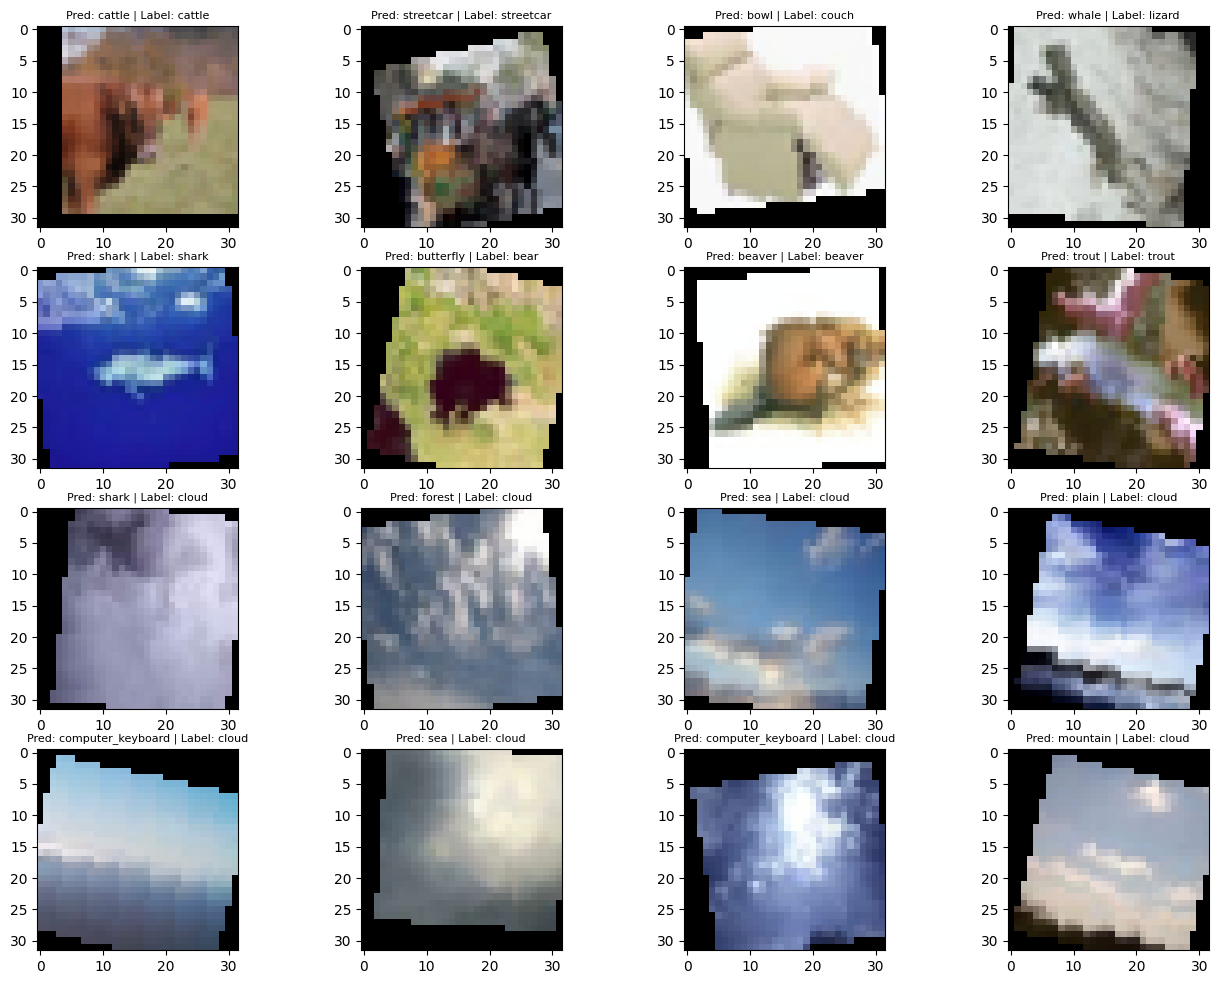

In [30]:
model.eval()
with torch.no_grad():
    # choose one batch from val and one batch from forget
    for (val_img, val_label), (forget_img, forget_label) in zip(
        val_viz_loader, forget_viz_loader
    ):
        viz_img, viz_label = torch.cat([val_img, forget_img]), torch.cat(
            [val_label, forget_label]
        )
        viz_img, viz_label = viz_img.to(device), viz_label.to(device)
        out = model(viz_img)
        pred = out.argmax(dim=-1)
        break

# assumes BATCH_SIZE=8
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
for i, ax in enumerate(axes.ravel()):
    ax.set_title(
        f"Pred: {fine_labels[pred[i]]} | Label: {fine_labels[viz_label[i]]}", fontsize=8
    )
    ax.imshow(invTrans(viz_img[i]).cpu().permute(1, 2, 0))
plt.show()